### Relative Comparison across Stations based on Grographies (not comparison to national medians).
    Prepared by: Mohammed Golam Kaisar Hossain Bhuyan
    09-May-2025

#### Setting up libraries

In [12]:
# pip install plotly

In [13]:
# pip install ipywidgets

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import plotly.graph_objects as go
import plotly.express as px


#### Loading files

In [15]:
# Load CSV
df = pd.read_csv("Final_Heighttest_with_footprints_output.csv")
df.head(2)

,station_id,StationName,ntd_mode,agency,line_name,facility_type,Year built,Square Feet,Latitude,Longitude,...,Outer_MaxHeight,Outer_MinHeight,Outer_AvgHeight,Outer_BuildingsWithHeight,Outer_TotalBuildings,Outer_TotalFootprint,Outer_AvgFootprint,HasStepDown_Inner_Middle,HasStepDown_Middle_Outer,ConsistentStepDown
0,36,ALAMEDA FERRY TERMINAL STATION,Ferry,Alameda/Oakland Ferry,Oakland / Alameda / San Francisco,Ferryboat Terminal,2023.0,NaN,37.791197,-122.294188,...,2.0,1.0,1.50,2,350,138976.44,397.08,False,False,False
1,37,OAKLAND FERRY TERMINAL STATION,Ferry,Alameda/Oakland Ferry,Oakland / Alameda / San Francisco,Ferryboat Terminal,1991.0,NaN,37.795011,-122.279758,...,15.0,1.0,3.18,84,522,336870.94,645.35,False,True,False


#### Duplicate and Null value handling

In [16]:
# Checking duplicated rows : No Duplication
df.duplicated().sum()

0

In [17]:
# Checking null values : Null Value Exists
df.isna().sum()
# Check the percentage of missing values in each column
missing_percentage = df.isnull().sum() / len(df) * 100
missing_percentage[missing_percentage > 0]

Year built           0.262044
Square Feet         17.375529
Zip_Code             0.322516
Inner_MaxHeight     42.934892
Inner_MinHeight     42.934892
Inner_AvgHeight     42.934892
Middle_MaxHeight    34.126184
Middle_MinHeight    34.126184
Middle_AvgHeight    34.126184
Outer_MaxHeight     19.552510
Outer_MinHeight     19.552510
Outer_AvgHeight     19.552510
dtype: float64

In [18]:
# Missing Data Analysis
# Square Feet is missing in 17.4% of records.
# Inner (200m) building heights are missing in 43% of records.
# Middle (400m) building heights are missing in 34% of records.
# Outer (800m) building heights are missing in 19.5% of records.

# Handling Missing Values
# Square Feet: Missing values are imputed using the median (to avoid outlier influence).
# Building Heights (Inner, Middle, Outer): Considering missing values is "no buildings," filled with 0.
# Year built and Zip_Code missing values are not significant for this analysis.

#### Cleaning up column names for visual representation

In [19]:
# Dataframe copy for processing
df_copy = df.copy(deep=True)
# df_copy.head()

# Rename columns for clarity
df_copy.rename(columns=lambda x: x.strip().replace(" ", "_"), inplace=True)
df_copy.columns

Index(['station_id', 'StationName', 'ntd_mode', 'agency', 'line_name',
       'facility_type', 'Year_built', 'Square_Feet', 'Latitude', 'Longitude',
       'full_address', 'City', 'State', 'County', 'Zip_Code',
       'Inner_MaxHeight', 'Inner_MinHeight', 'Inner_AvgHeight',
       'Inner_BuildingsWithHeight', 'Inner_TotalBuildings',
       'Inner_TotalFootprint', 'Inner_AvgFootprint', 'Middle_MaxHeight',
       'Middle_MinHeight', 'Middle_AvgHeight', 'Middle_BuildingsWithHeight',
       'Middle_TotalBuildings', 'Middle_TotalFootprint', 'Middle_AvgFootprint',
       'Outer_MaxHeight', 'Outer_MinHeight', 'Outer_AvgHeight',
       'Outer_BuildingsWithHeight', 'Outer_TotalBuildings',
       'Outer_TotalFootprint', 'Outer_AvgFootprint',
       'HasStepDown_Inner_Middle', 'HasStepDown_Middle_Outer',
       'ConsistentStepDown'],
      dtype='object')

In [20]:
# Fill missing values in Square Feet with median data
df['Square Feet'] = df['Square Feet'].fillna(df['Square Feet'].median())

# Fill missing building height values with 0 (assuming missing means no buildings)
height_columns = ['Inner_MaxHeight', 'Inner_MinHeight', 'Inner_AvgHeight',
                  'Middle_MaxHeight', 'Middle_MinHeight', 'Middle_AvgHeight',
                  'Outer_MaxHeight', 'Outer_MinHeight', 'Outer_AvgHeight']

df[height_columns] = df[height_columns].fillna(0)

# # Verify missing values are handled
# df.isnull().sum()  # Should return 0 if all missing values are filled

### Classic TOD
    "Classic TOD" represents patters where Average Height and Average Footprint decrease as we move out from 200 m to 400 m to 800 m but Building Count increase.

In [21]:

# 1. Define the three boolean conditions

# A) Heights decrease: 200 m > 400 m > 800 m
cond_height = (
    (df['Inner_AvgHeight'] > df['Middle_AvgHeight']) &
    (df['Middle_AvgHeight'] > df['Outer_AvgHeight'])
)

# cond_height.head()

# B) Footprint decreases: 200 m > 400 m > 800 m
cond_footprint = (
    (df['Inner_TotalFootprint'] > df['Middle_TotalFootprint']) &
    (df['Middle_TotalFootprint'] > df['Outer_TotalFootprint'])
)

# C) Building counts increase: 200 m < 400 m < 800 m
cond_buildings = (
    (df['Inner_TotalBuildings'] < df['Middle_TotalBuildings']) &
    (df['Middle_TotalBuildings'] < df['Outer_TotalBuildings'])
)

# 2. Combine all three for the “Classic TOD” pattern
classic_tod_mask = cond_height & cond_footprint & cond_buildings
classic_tod = df[classic_tod_mask]

# 3. Report the count
print(f"Stations matching Classic TOD pattern: {len(classic_tod)} out of {len(df)}")

# 4. See which stations they are
classic_tod[['station_id','StationName','line_name','agency']]

# 5. Adding a Column 'Topology' to the Dataframe and mark it according to the type
df['Typology'] = 'Other'
df.loc[classic_tod_mask, 'Typology'] = 'Classic'

Stations matching Classic TOD pattern: 0 out of 4961


### The Donut
    In "Donut" assessment, 200 m radious has the lowest Building Average Height, Building Average Footprint, and Building Count, and all
    of these three metrics increase as we move outward to 400 m and to 800 m.

In [23]:
# Donut pattern conditions:

# Heights: 200 m < 400 m < 800 m
cond_height_donut = (
    (df['Inner_AvgHeight'] < df['Middle_AvgHeight']) &
    (df['Middle_AvgHeight'] < df['Outer_AvgHeight'])
)

# Footprint: 200 m < 400 m < 800 m
cond_footprint_donut = (
    (df['Inner_TotalFootprint'] < df['Middle_TotalFootprint']) &
    (df['Middle_TotalFootprint'] < df['Outer_TotalFootprint'])
)

# Building counts: 200 m < 400 m < 800 m
cond_buildings_donut = (
    (df['Inner_TotalBuildings'] < df['Middle_TotalBuildings']) &
    (df['Middle_TotalBuildings'] < df['Outer_TotalBuildings'])
)

# Combine all three conditions
donut_mask = cond_height_donut & cond_footprint_donut & cond_buildings_donut
donut_typology = df[donut_mask]

# Print count and preview
print(f"Stations matching Donut pattern: {len(donut_typology)} out of {len(df)}")

# View relevant station columns
donut_typology[['station_id', 'StationName', 'line_name', 'agency']]

# Updating 'Topology' and mark it according to the type
df.loc[donut_mask, 'Typology'] = 'Donut'

Stations matching Donut pattern: 687 out of 4961


### Monoculture
    "Monoculture" represents patters where Average Height, Average Footprint and Building Count doesn't increase or decrease 
    (remain the same) as we move out from 200 m to 400 m to 800 m.

In [25]:
# Tolerance for "same" – adjust based on scale of your data
TOL_HEIGHT = 1.0            # meters
TOL_FOOTPRINT = 1000        # square meters
TOL_BUILDINGS = 3           # number of buildings

# Height same across all radii
cond_height_mono = (
    (abs(df['Inner_AvgHeight'] - df['Middle_AvgHeight']) <= TOL_HEIGHT) &
    (abs(df['Middle_AvgHeight'] - df['Outer_AvgHeight']) <= TOL_HEIGHT)
)

# Footprint same
cond_footprint_mono = (
    (abs(df['Inner_TotalFootprint'] - df['Middle_TotalFootprint']) <= TOL_FOOTPRINT) &
    (abs(df['Middle_TotalFootprint'] - df['Outer_TotalFootprint']) <= TOL_FOOTPRINT)
)

# Building counts same
cond_buildings_mono = (
    (abs(df['Inner_TotalBuildings'] - df['Middle_TotalBuildings']) <= TOL_BUILDINGS) &
    (abs(df['Middle_TotalBuildings'] - df['Outer_TotalBuildings']) <= TOL_BUILDINGS)
)

# Combine all
monoculture_mask = cond_height_mono & cond_footprint_mono & cond_buildings_mono
monoculture_typology = df[monoculture_mask]

print(f"Stations matching Monoculture pattern: {len(monoculture_typology)} out of {len(df)}")

# View some station details
monoculture_typology[['station_id', 'StationName', 'line_name', 'agency']]

# Updating 'Topology' and mark it according to the type
df.loc[monoculture_mask, 'Typology'] = 'Monoculture'

Stations matching Monoculture pattern: 13 out of 4961


### Station Typology Charts

<Axes: title={'center': 'Station Typology Count'}, xlabel='Typology'>

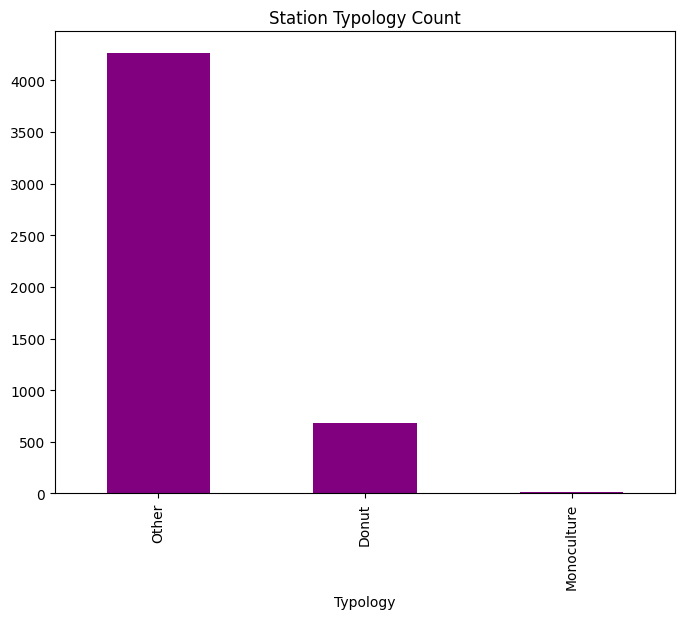

In [42]:
# Count
df['Typology'].value_counts().plot(kind='bar', color='purple', figsize=(8, 6), title='Station Typology Count')


<Axes: title={'center': 'Typology for Heavy Rail'}, xlabel='Typology'>

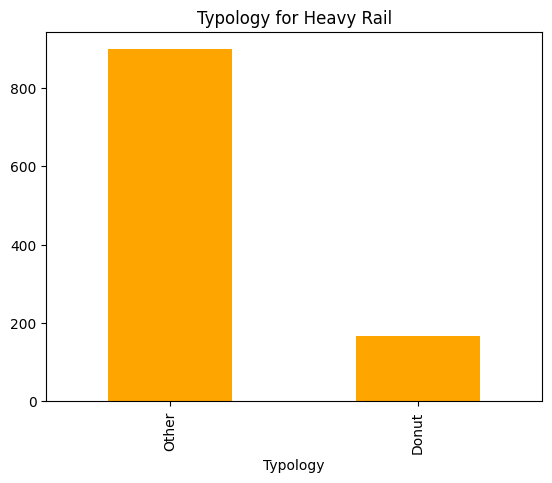

In [28]:
# Filter for Transfer Mode: heavy rail only
df_rail = df[df['ntd_mode'] == 'Heavy Rail']

# Count Monoculture vs Others
df_rail['Typology'].value_counts().plot(kind='bar', title='Typology for Heavy Rail', color='orange')


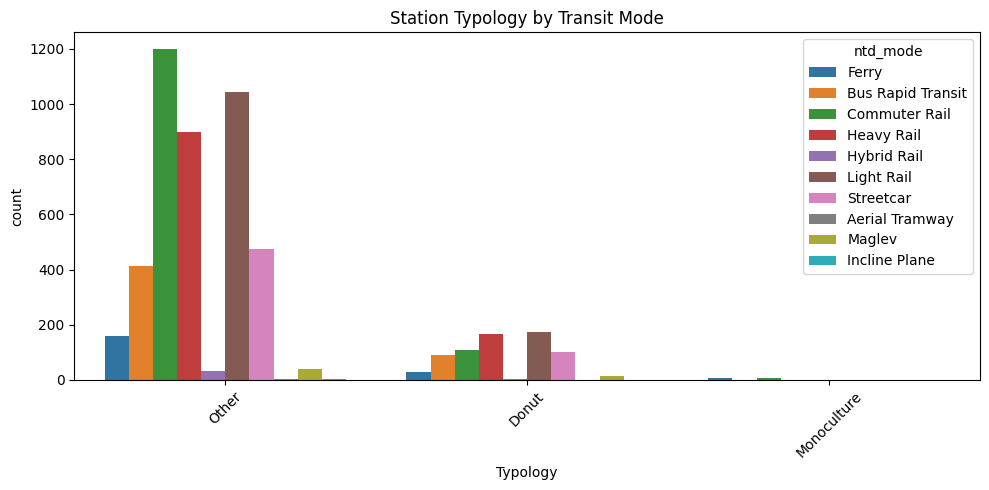

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt

# Count by Typology and Transit Mode
plt.figure(figsize=(10,5))
sns.countplot(data=df, x='Typology', hue='ntd_mode')
plt.title('Station Typology by Transit Mode')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [33]:
# Saving into new file with refined data and 'Topology' column for Streamlit visualization

df.to_csv('Final_Heighttest_with_footprints_output_typology.csv', index=False)

In [34]:
df2 = pd.read_csv("Final_Heighttest_with_footprints_output_typology.csv")
df2.head(2)

,station_id,StationName,ntd_mode,agency,line_name,facility_type,Year built,Square Feet,Latitude,Longitude,...,Outer_MinHeight,Outer_AvgHeight,Outer_BuildingsWithHeight,Outer_TotalBuildings,Outer_TotalFootprint,Outer_AvgFootprint,HasStepDown_Inner_Middle,HasStepDown_Middle_Outer,ConsistentStepDown,Typology
0,36,ALAMEDA FERRY TERMINAL STATION,Ferry,Alameda/Oakland Ferry,Oakland / Alameda / San Francisco,Ferryboat Terminal,2023.0,11700.0,37.791197,-122.294188,...,1.0,1.50,2,350,138976.44,397.08,False,False,False,Other
1,37,OAKLAND FERRY TERMINAL STATION,Ferry,Alameda/Oakland Ferry,Oakland / Alameda / San Francisco,Ferryboat Terminal,1991.0,11700.0,37.795011,-122.279758,...,1.0,3.18,84,522,336870.94,645.35,False,True,False,Other


In [35]:
# End